**HOMEWORK**  

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').  

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) or download using wget link mentioned below:

```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

```



In [3]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [ ]:
#@ DOWNLOADING THE DATASET: UNCOMMENT BELOW:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [4]:
#@ READING DATASET:
PATH = "./housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

- Apply the log transform to `median_house_value`. 
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the `train_test_split` function and set the `random_state parameter` to 1.

In [6]:
#@ apply log transform to median_house_value
df["median_house_value"] = np.log1p(df["median_house_value"])

In [7]:
#@ SPLITTING THE DATASET FOR TRAINING AND TEST:
X = df.drop(columns=['median_house_value'])
y = df['median_house_value']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=1)

- We will use `DictVectorizer` to turn train and validation into matrices.

In [8]:
#@ IMPLEMENTATION OF DICTVECTORIZER:
train_dict = X_train.to_dict(orient='records')
val_dict = X_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)
X_val = dv.transform(val_dict)

**Question 1**

Let's train a decision tree regressor to predict the `median_house_value` variable.

Train a model with `max_depth=1`.

In [9]:
#@ TRAINING THE REGRESSION MODEL:
model_dt = DecisionTreeRegressor(max_depth=1)
model_dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [10]:
#@ INSPECTION:
from sklearn.tree import export_text

print(export_text(model_dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/home/test/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


- Which feature is used for splitting the data?

- Answer: Ocean porximity

**Question 2**

Train a random forest model with these parameters:

- `n_estimators=10`  
- `random_state=1`  
- `n_jobs=-1` (optional-to make training faster)

In [11]:
#@ TRAINING RANDOM FOREST MODEL:
model_rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
model_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [14]:
#@ CALCULATING MEAN SQUARED ERROR:
y_pred = model_rf.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
round(rmse, 2)

0.25

- What's the RMSE of this model on validation?

- Answer: 0.25

**Question 3**

Now, let's experiment with the `n_estimators` parameter.

- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to 1.
- Evaluate the model on the validation dataset.

In [18]:
#@ TRAINING THE RANDOM FOREST MODEL:
num_estimators = range(10, 201, 10)

rmse_scores = []
for n in tqdm(num_estimators):
    model_rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    model_rf.fit(X_train, y_train)
    y_pred = model_rf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print(n, round(rmse, 2))
    rmse_scores.append(rmse)

  0%|          | 0/20 [00:00<?, ?it/s]

10 0.25
20 0.24
30 0.24
40 0.23
50 0.23
60 0.23
70 0.23
80 0.23
90 0.23
100 0.23
110 0.23
120 0.23
130 0.23
140 0.23
150 0.23
160 0.23
170 0.23
180 0.23
190 0.23
200 0.23


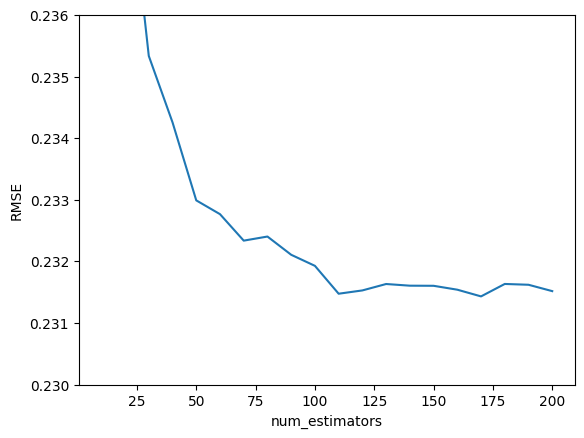

In [22]:
#@ INSPECTING THE RMSE SCORES:
# plot num_estimators vs rmse
plt.plot(num_estimators, rmse_scores)
plt.ylim(0.23, 0.236)
plt.xlabel("num_estimators")
plt.ylabel("RMSE");

- After which value of `n_estimators` does RMSE stop improving?

- Answer: 110 or 150

**Question 4**

Let's select the best `max_depth`:

- Try different values of `max_depth`: [10, 15, 20, 25].
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10).
- Fix the random seed: `random_state=1`.

In [23]:
#@ TRAINING THE MODEL WITH DEPTH:
max_depth = [10, 15, 20, 25]
rmse_scores_2 = []
for md in max_depth:
    for n in num_estimators:
        model_rf = RandomForestRegressor(n_estimators=n, max_depth=md, random_state=1, n_jobs=-1)
        model_rf.fit(X_train, y_train)
        y_pred = model_rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        print(md, n, round(rmse, 3))
        rmse_scores_2.append(rmse)

10 10 0.255
10 20 0.253
10 30 0.251
10 40 0.251
10 50 0.25
10 60 0.25
10 70 0.25
10 80 0.25
10 90 0.249
10 100 0.249
10 110 0.249
10 120 0.249
10 130 0.249
10 140 0.249
10 150 0.249
10 160 0.249
10 170 0.249
10 180 0.249
10 190 0.249
10 200 0.249
15 10 0.245
15 20 0.239
15 30 0.237
15 40 0.236
15 50 0.235
15 60 0.235
15 70 0.234
15 80 0.234
15 90 0.234
15 100 0.234
15 110 0.233
15 120 0.233
15 130 0.233
15 140 0.233
15 150 0.233
15 160 0.233
15 170 0.233
15 180 0.233
15 190 0.233
15 200 0.233
20 10 0.246
20 20 0.238
20 30 0.236
20 40 0.235
20 50 0.233
20 60 0.233
20 70 0.233
20 80 0.233
20 90 0.232
20 100 0.232
20 110 0.232
20 120 0.232
20 130 0.232
20 140 0.232
20 150 0.232
20 160 0.232
20 170 0.232
20 180 0.232
20 190 0.232
20 200 0.232
25 10 0.246
25 20 0.239
25 30 0.236
25 40 0.235
25 50 0.233
25 60 0.233
25 70 0.232
25 80 0.232
25 90 0.232
25 100 0.232
25 110 0.231
25 120 0.231
25 130 0.232
25 140 0.231
25 150 0.232
25 160 0.231
25 170 0.231
25 180 0.232
25 190 0.232
25 200 0.231


In [31]:
i//len(num_estimators)

3

In [27]:
list(range(0, len(rmse_scores_2), len(num_estimators)))

[0, 20, 40, 60]

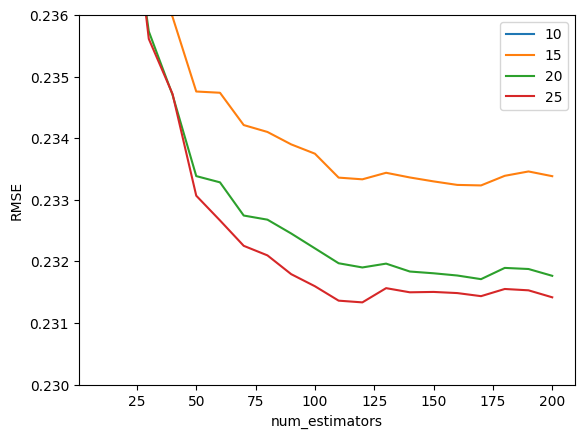

In [26]:
# for each max_depth, plot num_estimators vs rmse
for i in range(0, len(rmse_scores_2), len(num_estimators)):
    plt.plot(num_estimators, rmse_scores_2[i:i+len(num_estimators)], label=max_depth[i//len(num_estimators)])
plt.ylim(0.23, 0.236)
plt.xlabel("num_estimators")
plt.ylabel("RMSE")
plt.legend();

- What's the best `max_depth`:

- Answer: 25

**Question 5**

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
- `n_estimators=10`,
- `max_depth=20`,
- `random_state=1`,
- `n_jobs=-1` (optional)

Get the feature importance information from this model

In [32]:
#@ TRAINING THE RANDOM FOREST MODEL:
model_rf = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=1, n_jobs=-1)
model_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_jobs=-1, random_state=1)

In [33]:
# get feature importances
importances = model_rf.feature_importances_
indices = np.argsort(importances)[::-1]


In [35]:
# get feature names
feature_names = dv.get_feature_names()
# print top 10 features
for i in range(10):
    print(f"{i+1}. feature {feature_names[indices[i]]} ({importances[indices[i]]})")

1. feature median_income (0.3553042433226908)
2. feature ocean_proximity=INLAND (0.3166706814020916)
3. feature latitude (0.10146727768569597)
4. feature longitude (0.09695290796023506)
5. feature housing_median_age (0.03427679350907294)
6. feature population (0.029854918513054097)
7. feature total_rooms (0.02209293700058652)
8. feature total_bedrooms (0.01838665317706599)
9. feature households (0.017514505115747727)
10. feature ocean_proximity=NEAR OCEAN (0.004795225191639865)


/home/test/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


- What's the most important feature?

- Answer: median_income

**Question 6**

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost.
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
```



In [36]:
#@ CREATING THE DMARTIX:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [37]:
# create a watchlist
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [39]:
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

#@ TRAINING THE XGBOOST MODEL FOR 100 ROUNDS:
model_xgb = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, early_stopping_rounds=10)

[0]	train-rmse:8.12733	val-rmse:8.13245
[1]	train-rmse:5.69586	val-rmse:5.70070
[2]	train-rmse:3.99540	val-rmse:4.00041
[3]	train-rmse:2.80712	val-rmse:2.81079
[4]	train-rmse:1.97834	val-rmse:1.98175
[5]	train-rmse:1.40218	val-rmse:1.40741
[6]	train-rmse:1.00099	val-rmse:1.00700
[7]	train-rmse:0.72751	val-rmse:0.73439
[8]	train-rmse:0.54190	val-rmse:0.55047
[9]	train-rmse:0.42167	val-rmse:0.43233
[10]	train-rmse:0.34481	val-rmse:0.35782
[11]	train-rmse:0.29835	val-rmse:0.31360
[12]	train-rmse:0.27095	val-rmse:0.28865
[13]	train-rmse:0.25268	val-rmse:0.27334
[14]	train-rmse:0.24295	val-rmse:0.26605
[15]	train-rmse:0.23555	val-rmse:0.26044
[16]	train-rmse:0.22630	val-rmse:0.25229
[17]	train-rmse:0.22233	val-rmse:0.24902
[18]	train-rmse:0.22029	val-rmse:0.24826
[19]	train-rmse:0.21791	val-rmse:0.24696
[20]	train-rmse:0.21580	val-rmse:0.24624
[21]	train-rmse:0.21160	val-rmse:0.24334
[22]	train-rmse:0.20975	val-rmse:0.24245
[23]	train-rmse:0.20904	val-rmse:0.24269
[24]	train-rmse:0.20703	va

In [40]:
y_pred = model_xgb.predict(dval)
rmse = mean_squared_error(y_val, y_pred, squared=False)
rmse

0.2263040575032991

- Now, change eta first to 0.1 and then to 0.01.

- Which eta leads to the best RMSE score on the validation dataset?

- Answer: 0.3

In [41]:
xgb_params = {  
    'eta': 0.1,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

#@ TRAINING THE XGBOOST MODEL FOR 100 ROUNDS:
model_xgb = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, early_stopping_rounds=10)
y_pred = model_xgb.predict(dval)
rmse = mean_squared_error(y_val, y_pred, squared=False)
rmse

[0]	train-rmse:10.44372	val-rmse:10.44938
[1]	train-rmse:9.40118	val-rmse:9.40684
[2]	train-rmse:8.46290	val-rmse:8.46831
[3]	train-rmse:7.61859	val-rmse:7.62391
[4]	train-rmse:6.85878	val-rmse:6.86368
[5]	train-rmse:6.17513	val-rmse:6.17987
[6]	train-rmse:5.55994	val-rmse:5.56437
[7]	train-rmse:5.00643	val-rmse:5.01061
[8]	train-rmse:4.50846	val-rmse:4.51264
[9]	train-rmse:4.06043	val-rmse:4.06461
[10]	train-rmse:3.65741	val-rmse:3.66135
[11]	train-rmse:3.29492	val-rmse:3.29877
[12]	train-rmse:2.96894	val-rmse:2.97284
[13]	train-rmse:2.67573	val-rmse:2.67979
[14]	train-rmse:2.41195	val-rmse:2.41587
[15]	train-rmse:2.17500	val-rmse:2.17928
[16]	train-rmse:1.96214	val-rmse:1.96662
[17]	train-rmse:1.77065	val-rmse:1.77536
[18]	train-rmse:1.59880	val-rmse:1.60396
[19]	train-rmse:1.44376	val-rmse:1.44910
[20]	train-rmse:1.30499	val-rmse:1.31054
[21]	train-rmse:1.18080	val-rmse:1.18646
[22]	train-rmse:1.06879	val-rmse:1.07469
[23]	train-rmse:0.96912	val-rmse:0.97546
[24]	train-rmse:0.87914	

0.2305416021993131

In [42]:
xgb_params = {  
    'eta': 0.01,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

#@ TRAINING THE XGBOOST MODEL FOR 100 ROUNDS:
model_xgb = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, early_stopping_rounds=10)
y_pred = model_xgb.predict(dval)
rmse = mean_squared_error(y_val, y_pred, squared=False)
rmse

[0]	train-rmse:11.48634	val-rmse:11.49225
[1]	train-rmse:11.37165	val-rmse:11.37753
[2]	train-rmse:11.25810	val-rmse:11.26397
[3]	train-rmse:11.14569	val-rmse:11.15153
[4]	train-rmse:11.03441	val-rmse:11.04022
[5]	train-rmse:10.92424	val-rmse:10.93003
[6]	train-rmse:10.81516	val-rmse:10.82094
[7]	train-rmse:10.70718	val-rmse:10.71290
[8]	train-rmse:10.60029	val-rmse:10.60598
[9]	train-rmse:10.49446	val-rmse:10.50009
[10]	train-rmse:10.38969	val-rmse:10.39532
[11]	train-rmse:10.28597	val-rmse:10.29160
[12]	train-rmse:10.18328	val-rmse:10.18889
[13]	train-rmse:10.08163	val-rmse:10.08723
[14]	train-rmse:9.98099	val-rmse:9.98657
[15]	train-rmse:9.88136	val-rmse:9.88695
[16]	train-rmse:9.78273	val-rmse:9.78832
[17]	train-rmse:9.68508	val-rmse:9.69063
[18]	train-rmse:9.58841	val-rmse:9.59394
[19]	train-rmse:9.49270	val-rmse:9.49823
[20]	train-rmse:9.39796	val-rmse:9.40346
[21]	train-rmse:9.30416	val-rmse:9.30966
[22]	train-rmse:9.21131	val-rmse:9.21680
[23]	train-rmse:9.11938	val-rmse:9.1248

4.264961152048471